In [1]:
import random
from src.draw_ordered_tanner_graph import draw_cx_list
from src.get_quits_codes import get_bpc_code, get_lpc_code
from src.circuit_from_cx_list import memory_experiment_circuit_from_cx_list
import numpy as np
from src.permute_within_each_stabilizer import random_permutation_within_each_stabilizer
from src.permute_single_stabilizer import permute_single_stabilizer_inplace
from collections import Counter
from src.distance_from_decoder import find_distance
import time
import sinter
from ldpc.sinter_decoders import SinterBpOsdDecoder
from src.cx_list_from_stabilizers_in_sequence import RotatedSurfaceCode

np.random.seed(42)

In [19]:
code = RotatedSurfaceCode(7, ordering='optimal')
cx_list = code.generate_cx_list()
lz = code.lz
lx = code.lx
ancilla_type, data_mapping, ancilla_mapping, flag_mapping= code.build_mappings()

In [2]:
cx_list, ancilla_type, data_mapping, ancilla_mapping, lz, lx = get_lpc_code(cx_order='theirs')

In [3]:
qubit_to_name = {v:k for k,v in data_mapping.items()}
qubit_to_name.update({v:k for k,v in ancilla_mapping.items()})

In [4]:
# separate the cxs such that they are done one stabilizer at a time
cx_list = sorted(cx_list, key=lambda x: x[1])

In [5]:
noisy_qubits = set(data_mapping.values()) | set(ancilla_mapping.values())
p_cx = 0.01
logical_type = 'Z'

In [6]:
def get_logical_error_rate():
    circ = memory_experiment_circuit_from_cx_list(
                    cx_list=cx_list,
                    ancilla_type=ancilla_type,
                    data_mapping=data_mapping,
                    ancilla_mapping=ancilla_mapping,
                    flag_mapping=dict(),  # No flag mapping used here
                    logicals=lz if logical_type == 'Z' else lx,
                    logical_type=logical_type,
                    p_cx=p_cx,
                    p_idle=0.,
                    number_of_cycles=1,
                    flag=False,
                    noisy_qubits=noisy_qubits
                )
    task = sinter.Task(circuit=circ)

    stats = sinter.collect(tasks=[task,],
                           num_workers=10,
                           max_shots=100000,
                           max_errors=1000,
                           decoders=['bposd'],
                           custom_decoders={
                               "bposd": SinterBpOsdDecoder(max_iter=10, osd_order=5, osd_method='OSD_E')}# max_iter=10000,osd_order=15)}
                           )
    for stat in stats:
        logical_error_rate = stat.errors / stat.shots
        logical_error_rate_error = np.sqrt(
            logical_error_rate * (1 - logical_error_rate) / stat.shots)
        break
    else:
        logical_error_rate = 0.0
        logical_error_rate_error = 0.0
    print(logical_error_rate, logical_error_rate_error)
    return circ

In [11]:
# random_permutation_within_each_stabilizer(cx_list)

In [7]:
circ = get_logical_error_rate()

0.3884781269254467 0.008554901738427009


In [8]:
def explanation_to_ancilla(explanation):
    ancillas = set()
    for error_location in explanation.circuit_error_locations:
        qubits = []
        for target in error_location.flipped_pauli_product:
            qubits.append(qubit_to_name[target.gate_target.value])
        ancillas_at_location = [q for q in qubits if q in ancilla_mapping]
        if len(ancillas_at_location) == 0:
            return None
        ancillas.update(ancillas_at_location)
    return random.choice(list(ancillas))

In [9]:
def get_minimal_error(method='stim'):
    circ = memory_experiment_circuit_from_cx_list(
                cx_list=cx_list,
                ancilla_type=ancilla_type,
                data_mapping=data_mapping,
                ancilla_mapping=ancilla_mapping,
                flag_mapping=dict(),  # No flag mapping used here
                logicals=lz if logical_type == 'Z' else lx,
                logical_type=logical_type,
                p_cx=p_cx,
                p_idle=0.,
                number_of_cycles=1,
                flag=False,
                noisy_qubits=noisy_qubits
            )


    if method == 'decoder':
        dist, minimal_error, error_tags, errors = find_distance(circ, max_bp_iterations=10,osd_order=5) #max_bp_iterations=10000,osd_order=15)



    elif method == 'stim':
        errors = circ.search_for_undetectable_logical_errors(
            dont_explore_edges_increasing_symptom_degree=False,
            dont_explore_detection_event_sets_with_size_above=6,
            dont_explore_edges_with_degree_above=9999,
            canonicalize_circuit_errors=True,
        )

    else:
        raise ValueError('Method must be either "decoder" or "stim"')



    hook_ancillas_in_minimal_error = [explanation_to_ancilla(explanation) for explanation in errors]
    hook_ancillas_in_minimal_error = [a for a in hook_ancillas_in_minimal_error if a is not None]
    return hook_ancillas_in_minimal_error, len(errors), errors

In [10]:
# start with hook errors on all ancillas, then keep only hook errors on ancillas in minimal error
for _ in range(1000):
    noisy_qubits = set(data_mapping.values()) | set(ancilla_mapping.values())
    bad_ancillas, distance, error_explanations = get_minimal_error()
    print('bad ancillas: ',bad_ancillas)
    print('full distance: ', distance)
    noisy_qubits = set(data_mapping.values()) | set(ancilla_mapping[a] for a in bad_ancillas) | set(q for a,q in ancilla_mapping.items() if logical_type in a)
    print('noisy qubits: ',noisy_qubits)
    while True:
        a = np.random.choice(bad_ancillas)
        permute_single_stabilizer_inplace(cx_list, a)
        bad_ancillas, new_distance, error_explanations = get_minimal_error()
        print('new distance: ', new_distance)
        if new_distance > distance:
            break

KeyboardInterrupt: 

In [17]:
noisy_qubits = set(data_mapping.values()) | set(ancilla_mapping.values())
circ = get_logical_error_rate()

0.04071679393567806 0.0010433304601166567


/Users/giladkishony/PycharmProjects/ldpc_optimization/src/draw_ordered_tanner_graph.py:106: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, connectionstyle="arc3, rad=0.1")


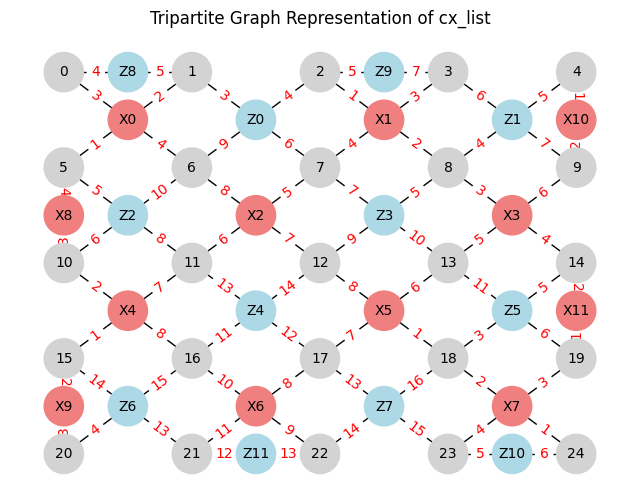

In [84]:
from src.draw_ordered_tanner_graph import draw_cx_list
draw_cx_list(cx_list, ancilla_type=ancilla_type, ancilla_coords=code.ancilla_coords, data_coords=code.data_coords)